In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Reference Model

In [2]:
# Loading trajectory
results=pd.read_csv('Resultscounty.txt',header=None,sep='\t')
results.columns=['ID','time','county','S','E','A','I','R','P','D']
# results=pd.merge(results,parameters,on='ID')
results.sort_values(['ID','time'],ascending=True,inplace=True)
dictionary=pd.read_csv('countydictionary.csv')
dictionary.columns=['COUNTY CODE','COUNTY NAME','county']
results=pd.merge(results,dictionary,on='county')
# results=resultspatch[['time','COUNTY NAME','S','E','A','I','R','P','D','beta','tauexposed','taupresymp','tauI','casefatalityrate','COUNTY CODE']]  
results=results[['ID','time','COUNTY NAME','S','E','A','I','R','P','D']]
results.loc[:,"S":"D"] = results.loc[:,"S":"D"].div(results.loc[:,"S":"D"].sum(axis =1), axis=0)

# Getting number of patches
patches = np.unique(results['COUNTY NAME'].values)
M = len(patches)
# Getting the time length
time = np.unique(results['time'].values)
T = len(time)
# Getting number of trajectories
IDs = np.unique(results['ID'].values)
N = len(IDs)
np.set_printoptions(threshold=np.inf)
# Number of compartments
C = 7
ref_traj = np.empty((N, T, M, C))
for n in IDs:
    for m, patch_name in enumerate(patches):
        ID = results.loc[results['ID'].isin([str(n)])]
        county = ID.loc[ID['COUNTY NAME'] == patch_name]
        traj_county = county[['S','E','A','I','R','P','D']].to_numpy()
        ref_traj[n,:,m,:] = traj_county
print (np.shape(ref_traj))

(10, 201, 62, 7)


Plotting 62 patches in a 7 x 9 grid


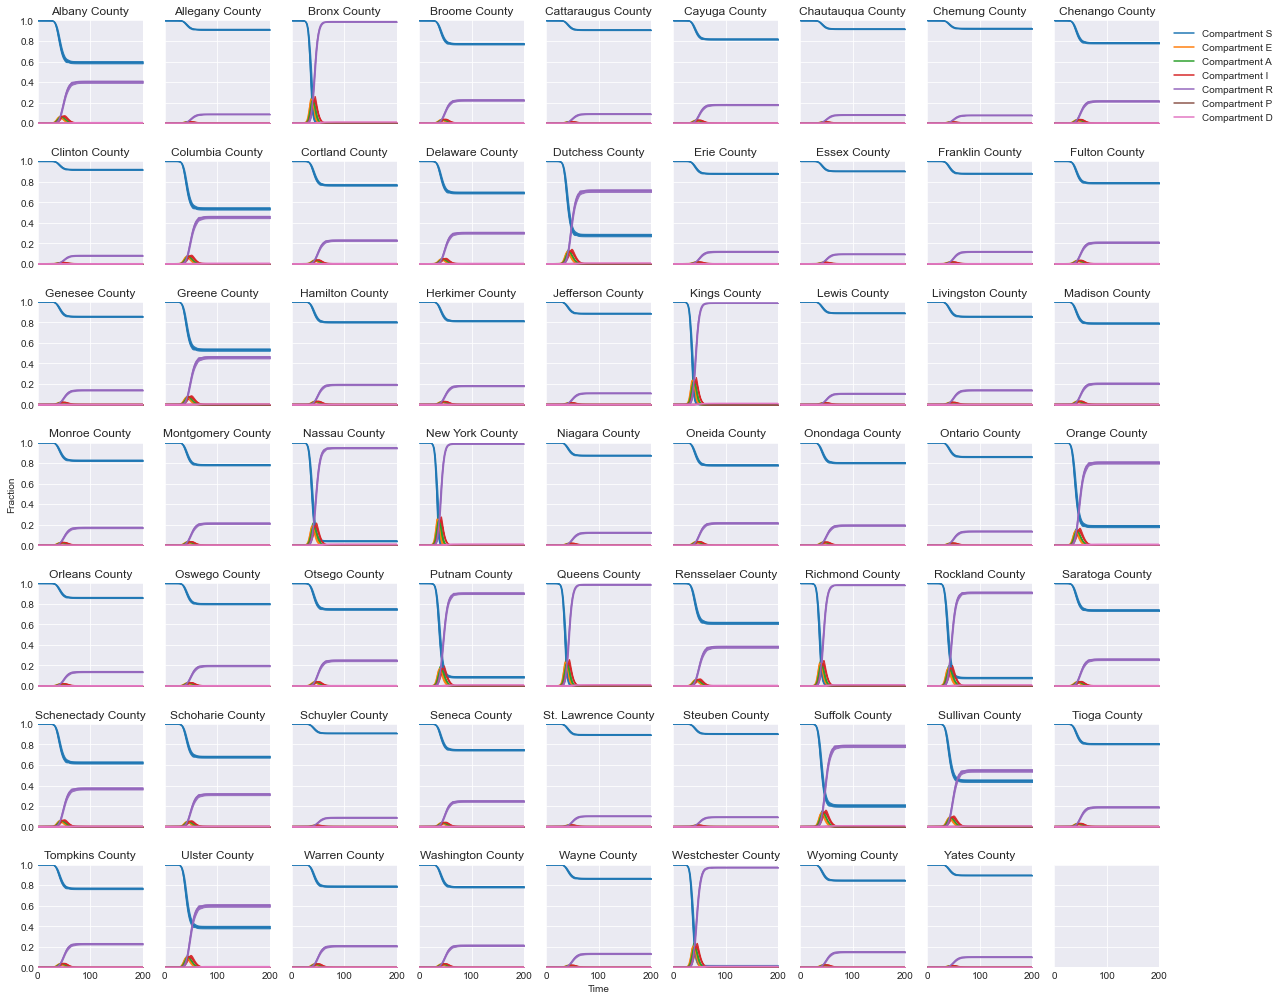

In [3]:
patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.9, names=['S','E','A','I','R','P','D'])
plt.savefig('patch_quantile.png',dpi=400)
plt.show()

In [4]:
# Run this for creating frames for animations
import plotly.graph_objs as go
import plotly.figure_factory as ff 
process_traj = False
if process_traj == True:
    for t in range(T):
        infected_portion = [round(ref_traj[0,t,i,3],2) for i in range(M)]
        zipcodes = dictionary['COUNTY CODE']
        fig = ff.create_choropleth(fips=zipcodes, 
                                   scope=['New York'],
                                   values=infected_portion,
                                   title='NY COVID-19 Infected Population Fraction by County',
                                   county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
                                   state_outline={'width': .5}
                                   )


        fig.update_layout(legend=dict(
            title='Infected Fraction',
            yanchor="top",
            y=0.95,
            xanchor="left",
            x=0.9,

        ))
        fig.add_annotation(dict(font=dict(color='black',size=30),
                                                x=0.4,
                                                y=0.12,
                                                showarrow=False,
                                                text="Day {}".format(t),
                                                textangle=0,
                                                xanchor='left',
                                                xref="paper",
                                                yref="paper"
                                                ))

        fig.layout.template = {'layout': {'font': {'family': 'Britannic Bold', 'size': 20}}}
        fig.write_image("NY_map//traj_" + str(t) +
                            ".png",width = 2048, height =1060)

In [5]:
# Run this for saving plots
if process_traj == True:
    for i in range(M):
        traj_quantile(ref_traj[:,:,i,:], names=['S','E','A','I','R','P','D'], add_legend=False, add_title = patches[i], plot_means=True)
        fig = plt.gcf()
        fig.set_size_inches(4, 4)
        #plt.savefig('{}.png'.format(patches[i]),dpi=400)
        plt.close()

In [6]:
# load mobility matrix
networkCounty=pd.read_csv('networkCounty.txt',header=None,sep=' ')
networkCounty.columns=['ID','County','mobility_parameter']
mobility_matrix = networkCounty.reset_index().groupby(['County'])['mobility_parameter'].apply(np.array).to_numpy()
networkCounty = networkCounty[['ID','mobility_parameter']]
Mobility_martix = np.empty([0,M])
mobility_parameter_row = np.zeros(M)
for i,row in networkCounty.iterrows():
    mobility_parameter_row[networkCounty.loc[i, 'ID']] = networkCounty.loc[i, 'mobility_parameter']
    if i < networkCounty.shape[0]-1:
        if networkCounty.loc[i+1, 'ID'] == 0:
            Mobility_martix = np.append(Mobility_martix, [mobility_parameter_row], axis=0)
            mobility_parameter_row = np.zeros(M)
    else:
         Mobility_martix = np.append(Mobility_martix, [mobility_parameter_row], axis=0)
assert (np.shape(Mobility_martix)==(M,M))
Mobility_martix_norm = Mobility_martix / np.sum(Mobility_martix, axis=1).reshape(M,1)

## Restraining a sample SEAIRPD to reference

In [91]:
# compartment parameters
compartments = ['E','A','I','R','P','D']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 150, 100)
tmat.add_transition('A', 'I', 3, 2)
tmat.add_transition('I', 'R', 200, 2)
tmat.add_transition('R', 'P', 3, 2)
tmat.add_transition('P', 'D', 3, 2)
# tmat.add_transition('I', 'R', 14, 4)
print(tmat.value)
param_model = maxentep.MetaParameterJoint(np.zeros((M,)), Mobility_martix_norm * 0.9, tmat, name='unbiased_model')

[[0.99333333 0.00666667 0.         0.         0.         0.        ]
 [0.         0.66666667 0.33333333 0.         0.         0.        ]
 [0.         0.         0.995      0.005      0.         0.        ]
 [0.         0.         0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.         0.         0.66666667 0.33333333]
 [0.         0.         0.         0.         0.         1.        ]]


In [92]:
import tqdm
N = 100
batches = 16
outs = []
infect = maxentep.contact_infection_func(infections_compartments)
model = maxentep.MetaModel(infect, T)
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|██████████| 16/16 [00:17<00:00,  1.06s/it]


(1600, 201, 62, 7)


## Make restraints from reference trajectory

80 0.4247349130030252 0.4299363988716352
3 0.0 0.005177883580792325
45 0.10667882630991607 0.03699970679005432
52 0.25897433740653264 0.28548995794069165
129 0.42545319999424275 0.39378841974840667
87 0.4253157041559711 0.3449480407238903
59 0.366303343662358 0.40126132690471517
101 0.42544844496203754 0.4281286566876348


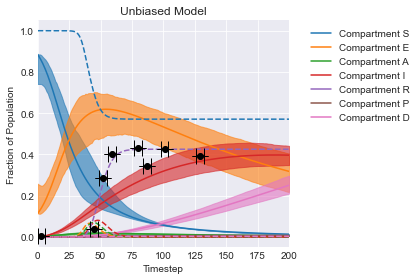

In [93]:
# Plotting restraints on reference traj
full_compartments = ['S'] + compartments
p = 1 # picking one trajectory from the parameter set
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[p,:,0], linestyle='--')
plt.title('Unbiased Model')

npoints =8
prior = maxentep.Laplace(0.1)
# cutting the ref_traj in half
restraints, plot_fxns = maxentep.traj_to_restraints(ref_traj[p,:150,:,:], [0,4], npoints, prior, noise=0.05,time_average=7)
for i,pf in enumerate(plot_fxns):
    pf(plt.gca(), 0)
plt.tight_layout()
plt.savefig('unbiased.png',dpi=200)
plt.show()


In [25]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [26]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [27]:
history = me_model.fit(trajs, batch_size=8,epochs=50, callbacks=[CustomCallback()])

Epoch 1/50
200/200 [==============================] - 0s 464us/step - loss: 0.0568 - weight-entropy: 1.8178
Epoch 2/50
200/200 [==============================] - 0s 464us/step - loss: 0.0438 - weight-entropy: 1.3600
Epoch 3/50
200/200 [==============================] - 0s 444us/step - loss: 0.0388 - weight-entropy: 1.0806
Epoch 4/50
200/200 [==============================] - 0s 444us/step - loss: 0.0345 - weight-entropy: 0.8487
Epoch 5/50
200/200 [==============================] - 0s 434us/step - loss: 0.0324 - weight-entropy: 0.7652
Epoch 6/50
200/200 [==============================] - 0s 434us/step - loss: 0.0303 - weight-entropy: 0.6725
Epoch 7/50
200/200 [==============================] - 0s 444us/step - loss: 0.0269 - weight-entropy: 0.5962
Epoch 8/50
200/200 [==============================] - 0s 459us/step - loss: 0.0242 - weight-entropy: 0.5506
Epoch 9/50
200/200 [==============================] - 0s 429us/step - loss: 0.0203 - weight-entropy: 0.5157
Epoch 10/50
200/200 [=======

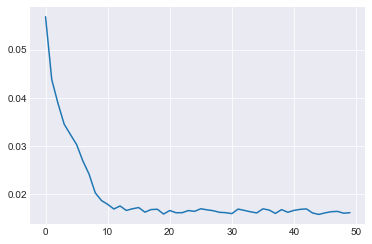

In [28]:
plt.plot(history.history['loss'])

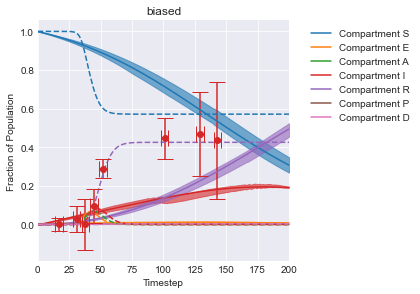

In [29]:
patch_number = 0
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(plt, me_model.lambdas[i], color='C3')
plt.tight_layout()
plt.title('biased')
plt.show()

In [37]:
weights = me_model.traj_weights
# plt.hist(weights)
# plt.show()
# plt.plot(me_model.lambdas.numpy(), 'o')

In [38]:
print (weights)

tf.Tensor(
[0.00079652 0.00041139 0.00072779 0.0010718  0.00070419 0.00043724
 0.00092894 0.00052164 0.00055208 0.00120459 0.00044515 0.00157116
 0.00045283 0.00060368 0.00054375 0.00058137 0.00041677 0.00042415
 0.00076958 0.00076276 0.00055196 0.00045758 0.00082682 0.00052529
 0.00052177 0.00054639 0.00079838 0.00068154 0.0005718  0.0009829
 0.00048416 0.0007555  0.00062385 0.00049203 0.00067608 0.00046668
 0.00039029 0.0005782  0.000391   0.0003957  0.00073536 0.000805
 0.00035739 0.00050165 0.00058844 0.00062621 0.00057392 0.00062783
 0.0005571  0.00054121 0.00041797 0.00061924 0.00049813 0.00058089
 0.00090891 0.00075457 0.00096303 0.00043378 0.00081327 0.00047853
 0.00069766 0.00052879 0.00042054 0.00033895 0.00080744 0.00053281
 0.00059845 0.00085295 0.00055494 0.00121975 0.00059383 0.00058456
 0.00047869 0.00032606 0.0005785  0.00040938 0.00057298 0.00044314
 0.00037117 0.00064999 0.000862   0.00079184 0.00121379 0.00040296
 0.0006454  0.00062494 0.00043112 0.00034739 0.0003740

## Algorithm 2

In [39]:
fit_param_model = maxentep.MetaParameterJoint(np.zeros((M,)), Mobility_martix_norm, tmat, name='unbiased_model')
fit_param_model.compile(tf.optimizers.Adam(0.1))
hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model)
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [41]:
history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=25, batch_size=32, epochs=8)

InvalidArgumentError: Invalid parameters [Op:ParameterizedTruncatedNormal]

In [42]:
history.history.keys()

dict_keys(['loss', 'weight-entropy'])

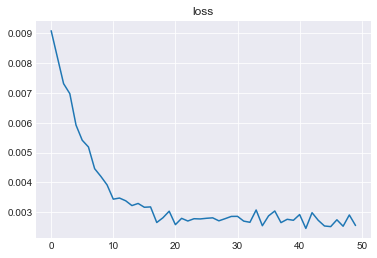

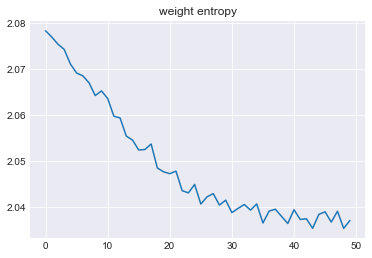

In [43]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()

plt.plot(history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

# plt.plot(history.history['prior-loss'])
# plt.title('neg log-likelihood')
# plt.show()

In [44]:
fit_param_model.get_layer('beta').trainable_variables,param_model.get_layer('beta').trainable_variables

([<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[nan]], dtype=float32)>],
 [<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.3025851]], dtype=float32)>])

In [45]:
fit_param_model.summary()

Model: "unbiased_model-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-dist-hypers (TrainableInputLa (None, 2, 62, 62)    7688        input_7[0][0]                    
__________________________________________________________________________________________________
R-dist-jitter (Lambda)          (None, 2, 62, 62)    0           R-dist-hypers[0][0]              
__________________________________________________________________________________________________
T-dist-hypers (TrainableInputLa (None, 2, 6, 6)      72          input_7[0][0]                    
_______________________________________________________________________________

In [46]:
fit_param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables,param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables

([<tf.Variable 'value:0' shape=(62,) dtype=float32, numpy=
  array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)>],
 [<tf.Variable 'value:0' shape=(62,) dtype=float32, numpy=
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>])

In [47]:
hme_fit = np.sum((hme_model.restraint_values * hme_model.traj_weights[:,np.newaxis]), axis=0)
me_fit =  np.sum((me_model.restraint_values * me_model.traj_weights[:,np.newaxis]), axis=0)
print(hme_fit, me_fit)
print(np.mean(hme_fit**2), np.mean(me_fit**2))

[nan nan nan nan nan nan nan nan] [-0.12889108  0.04028874 -0.04516562  0.11238328  0.01848511 -0.07529741
  0.13764219  0.08827326]
nan 0.00820687


In [48]:
eh = -np.sum(hme_model.traj_weights * np.log(hme_model.traj_weights))
e =  -np.sum(me_model.traj_weights * np.log(me_model.traj_weights))
print('Maxent', e, 'after tuning', eh)

Maxent 7.3270154 after tuning nan


## Direct Regression of Model

In [49]:
T = tmat.value
start = np.zeros((M, C))
start[0,0] = 0.5
infect = maxentep.ContactInfectionLayer(0.1, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, Mobility_martix_norm, T, infect, 201, agreement)

In [50]:
rmodel.compile(optimizer=tf.keras.optimizers.Adam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(100)
rtraj = rmodel.get_traj()

100/100 [==============================] - 7s 67ms/step - loss: 0.0723 - output_2_loss: 0.0723


## Visualizing results

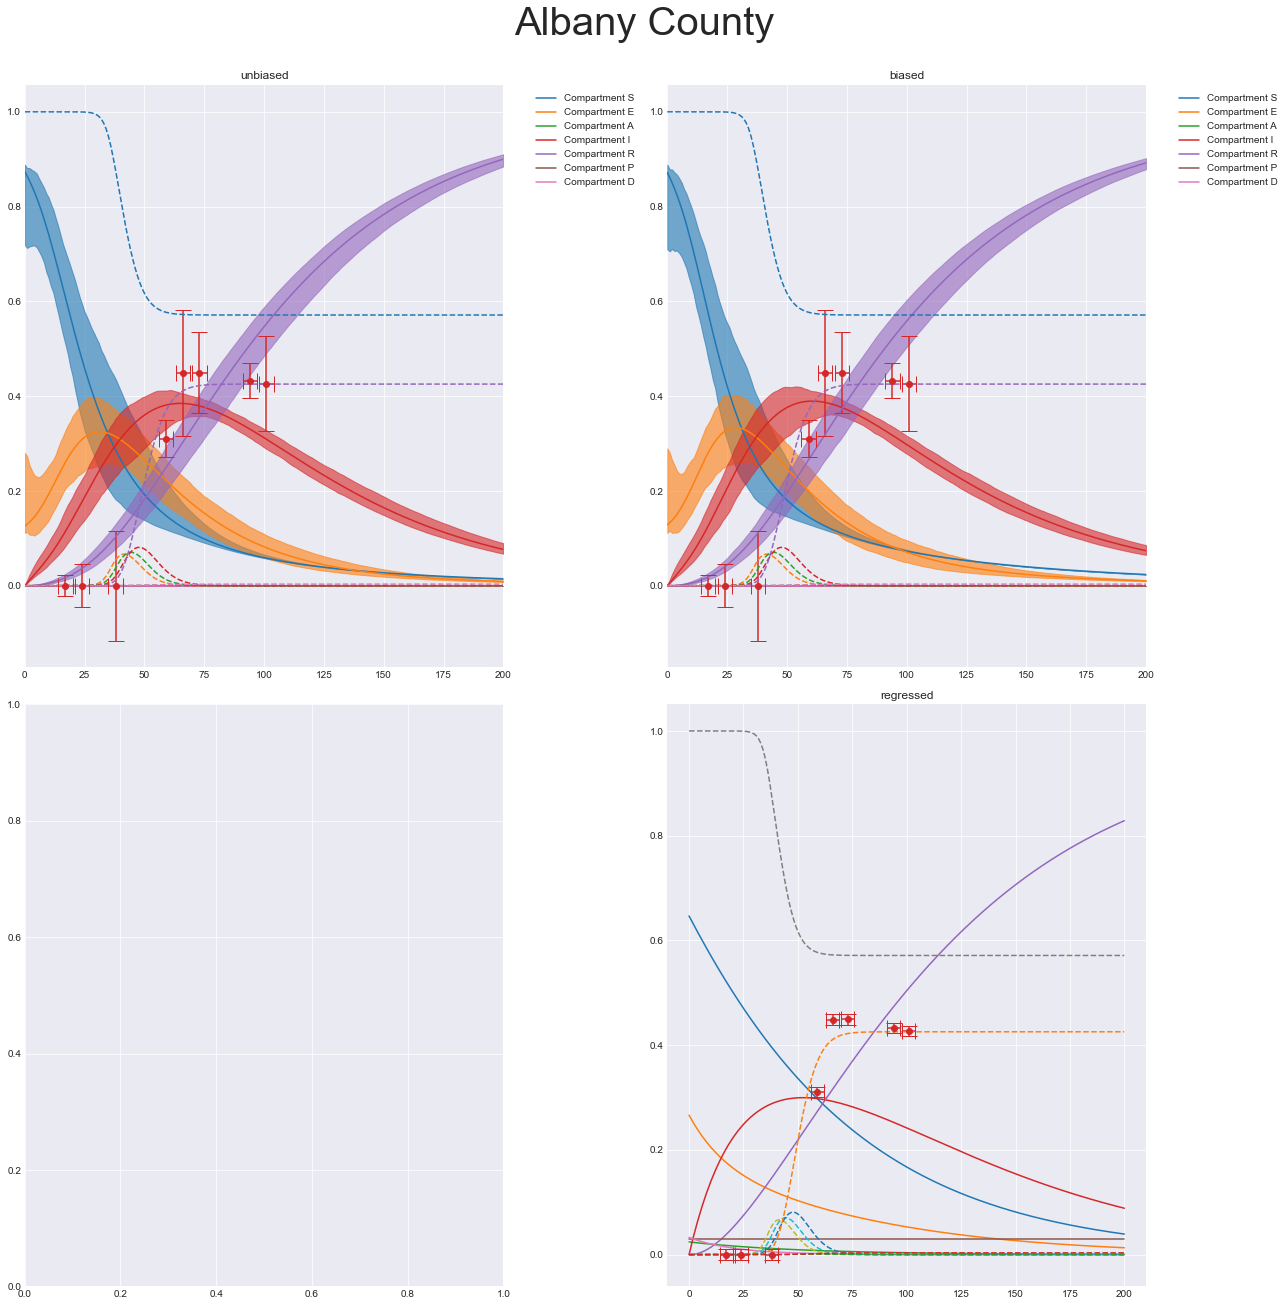

In [51]:
patch_number = 0
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

# axs[1,0].set_title('hyper-biased')
# maxentep.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
# axs[1,0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
# axs[1,0].plot(ref_traj[:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[1,0], hme_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('compare_biased.png', dpi = 300)